In [5]:
# =============================================================================
# COMPREHENSIVE FOOD PRICE FORECASTING ANALYSIS
# Comparing Auto ARIMA, Prophet, and Neural Prophet Methods
# =============================================================================

# --- 1. SETUP AND DATA PREPARATION ---
if (!require("forecast")) install.packages("forecast")
if (!require("prophet")) install.packages("prophet")
if (!require("reticulate")) install.packages("reticulate")
if (!require("dplyr")) install.packages("dplyr")
if (!require("ggplot2")) install.packages("ggplot2")
if (!require("tidyr")) install.packages("tidyr")
if (!require("lubridate")) install.packages("lubridate")
if (!require("gridExtra")) install.packages("gridExtra")
if (!require("grid")) install.packages("grid")


library(forecast)
library(prophet)
library(reticulate)
library(dplyr)
library(ggplot2)
library(tidyr)
library(lubridate)
library(gridExtra)
library(grid)
# Load data from Kaggle dataset
df <- read.csv("/kaggle/input/retail-dataset/Food Prices.csv")

# Create proper date column
df$date <- as.Date(paste(df$Year, df$Month, "01", sep = "-"))

# Filter for Australia data
australia_data <- df %>% 
  filter(Country == "Australia") %>%
  arrange(date)

# Create food_items list
food_items <- list(
  "Bread" = australia_data %>% filter(Food.Item == "Bread"),
  "Milk" = australia_data %>% filter(Food.Item == "Milk"),
  "Eggs" = australia_data %>% filter(Food.Item == "Eggs"),
  "Potatoes" = australia_data %>% filter(Food.Item == "Potatoes")
)

cat("Food items created successfully:\n")
for(item in names(food_items)) {
  cat(paste("-", item, ":", nrow(food_items[[item]]), "observations\n"))
}



Food items created successfully:
- Bread : 60 observations
- Milk : 60 observations
- Eggs : 60 observations
- Potatoes : 60 observations


In [6]:
# --- 2. COMPREHENSIVE FORECASTING FUNCTION ---

# Add after library imports in Cell 1
get_legend <- function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}


comprehensive_forecast_analysis <- function(data, item_name) {
  
  cat("\n", paste(rep("=", 60), collapse = ""), "\n")
  cat("ANALYZING:", item_name, "\n")
  cat(paste(rep("=", 60), collapse = ""), "\n")
  
  # Split data into training and testing sets
  train_data <- data %>% filter(date >= as.Date('2020-01-01') & date <= as.Date('2022-06-01'))
  test_data <- data %>% filter(date >= as.Date('2022-07-01') & date <= as.Date('2022-12-01'))
  
  # Get actual test values for later comparison
  test_actuals <- test_data$Average.Price
  test_dates <- test_data$date
  forecast_periods <- length(test_actuals)
  
  # Prepare training data
  ts_train <- ts(train_data$Average.Price, 
                start = c(min(train_data$Year), min(train_data$Month)), 
                frequency = 12)
  
# --- FEATURE ENGINEERING (FPP3 Chapter 7) ---
cat("Performing Feature Engineering...\n")

# Add basic trend feature to training data
train_data$time_idx <- 1:nrow(train_data)

# Create new time index for test data
new_time_idx <- (nrow(train_data) + 1):(nrow(train_data) + length(test_dates))

# Create test_features dataframe FIRST (before using it)
test_features <- data.frame(
  time_idx = new_time_idx,
  date = test_dates
)

# Add seasonal indicators to both datasets
train_data$month <- lubridate::month(train_data$date)
train_data$quarter <- lubridate::quarter(train_data$date)
test_features$month <- lubridate::month(test_features$date)

# Add lag features (previous month, previous year) to training data
train_data$lag1 <- c(NA, head(train_data$Average.Price, -1))
train_data$lag12 <- c(rep(NA, 12), head(train_data$Average.Price, -12))

# Add lag1 to test features
test_features$lag1 <- c(tail(train_data$Average.Price, 1), head(test_actuals, -1))

# Add lag12 to test features
all_prices <- c(tail(train_data$Average.Price, 12), test_actuals)
test_features$lag12 <- head(all_prices, length(test_features$time_idx))

# Price acceleration features
train_data$price_diff <- c(NA, diff(train_data$Average.Price))
train_data$price_diff[is.na(train_data$price_diff)] <- mean(train_data$price_diff, na.rm=TRUE)

# FIXED: Safe calculation of price_diff for test features
if (length(test_features$lag1) > 1) {
  # If we have multiple test points, calculate differences
  test_features$price_diff <- c(
    # Last difference from training data
    tail(train_data$Average.Price, 1) - tail(train_data$Average.Price, 2)[1],
    # Differences between test points
    diff(test_features$lag1)
  )
} else {
  # If we only have one test point, use the last difference from training
  test_features$price_diff <- tail(train_data$Average.Price, 1) - tail(train_data$Average.Price, 2)[1]
}

# Growth rate feature for training data
# More reliable growth rate calculation
prices <- train_data$Average.Price
n <- length(prices)
growth_rates <- numeric(n-1)

for (i in 2:n) {
  growth_rates[i-1] <- (prices[i] - prices[i-1]) / prices[i-1]
}

train_data$growth_rate <- c(NA, growth_rates)
train_data$growth_rate[is.na(train_data$growth_rate)] <- mean(train_data$growth_rate, na.rm=TRUE)

# FIXED: Safe calculation of growth_rate for test features
test_features$growth_rate <- numeric(length(test_dates))
# First point growth rate
test_features$growth_rate[1] <- tail(train_data$Average.Price, 1) / tail(train_data$Average.Price, 2)[1] - 1
# Remaining points growth rate if any
if (length(test_features$lag1) > 1) {
  for(i in 2:length(test_dates)) {
    test_features$growth_rate[i] <- test_features$lag1[i] / test_features$lag1[i-1] - 1
  }
}
test_features$growth_rate[is.na(test_features$growth_rate)] <- mean(train_data$growth_rate, na.rm=TRUE)

# Add quadratic trend terms to both datasets
train_data$time_idx_sq <- train_data$time_idx^2
test_features$time_idx_sq <- test_features$time_idx^2

# Add month-trend interaction
train_data$month_trend <- interaction(train_data$month, round(train_data$time_idx/3))

# Add trend feature
train_data$trend <- 1:nrow(train_data)

# Add moving averages to training data
train_data$ma3 <- stats::filter(train_data$Average.Price, rep(1/3, 3), sides = 1)
train_data$ma12 <- stats::filter(train_data$Average.Price, rep(1/12, 12), sides = 1)

# Initialize ma3 for test features with proper numeric type
test_features$ma3 <- numeric(length(test_dates))

# Calculate ma3 for test data with proper handling of transitions
last_vals <- tail(train_data$Average.Price, 2)
for(i in 1:length(test_dates)) {
  if(i == 1) {
    # First point uses 2 training values + 1 test value
    test_features$ma3[i] <- mean(c(last_vals, test_actuals[1]))
  } else if(i == 2) {
    # Second point uses 1 training value + 2 test values
    test_features$ma3[i] <- mean(c(last_vals[2], test_actuals[1:2]))
  } else {
    # Rest use 3 consecutive test values
    test_features$ma3[i] <- mean(test_actuals[(i-2):i])
  }
}

# Replace NA values with column means in training data
train_data <- train_data %>%
  mutate(across(c(lag1, lag12, ma3, ma12), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))

# --- IMPROVED LINEAR REGRESSION ---
cat("Running Enhanced Linear Regression...\n")

# 1. First, add the new features to both train and test datasets
# Add lag3 and lag6 features to training data
train_data$lag3 <- c(rep(NA, 3), head(train_data$Average.Price, -3))
train_data$lag6 <- c(rep(NA, 6), head(train_data$Average.Price, -6))

# Add lag3 to test features - use available data from training and test
if(nrow(train_data) >= 3) {
  lag3_values <- c(tail(train_data$Average.Price, 3)[1:min(3, length(test_dates))], 
                  head(test_actuals, -3))
  test_features$lag3 <- lag3_values[1:length(test_dates)]
} else {
  test_features$lag3 <- test_features$lag1  # Fallback if not enough data
}

# Add lag6 to test features - use available data from training and test
if(nrow(train_data) >= 6) {
  lag6_values <- c(tail(train_data$Average.Price, 6)[1:min(6, length(test_dates))], 
                  head(test_actuals, -6))
  test_features$lag6 <- lag6_values[1:length(test_dates)]
} else {
  test_features$lag6 <- test_features$lag1  # Fallback if not enough data
}

# 2. Create Fourier terms for both training and test data
train_data$month_sine <- sin(2*pi*month(train_data$date)/12)
train_data$month_cosine <- cos(2*pi*month(train_data$date)/12)

test_features$month_sine <- sin(2*pi*month(test_features$date)/12)
test_features$month_cosine <- cos(2*pi*month(test_features$date)/12)

# 3. Create interaction term for both datasets
train_data$month_sine_lag1 <- train_data$month_sine * train_data$lag1
test_features$month_sine_lag1 <- test_features$month_sine * test_features$lag1

# 4. Replace NA values in the new columns
train_data <- train_data %>%
  mutate(across(c(lag3, lag6, month_sine_lag1), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))

# --- OPTIMIZED LINEAR REGRESSION WITH FOOD-SPECIFIC PARAMETERS ---


# Food item-specific modeling
if(item_name == "Bread" || item_name == "Eggs") {
  # Keep current parameters for Bread and Eggs as they work well
  lm_model <- lm(Average.Price ~ time_idx + 
                lag1 + price_diff + 
                month_sine + month_cosine + ma3, 
                data = train_data)
                
} else if(item_name == "Milk") {

  # Define change_point for milk (around 2022-01-01)
  change_point <- 30  # Corresponds to ~Jan 2022 in the dataset
  
  # Create forecast_change_point for ARIMA external regressor
  forecast_change_point <- rep(1, forecast_periods)  # Simple dummy regressor

    
  # Milk-specific model - observed plateau pattern in Australian data
  # Similar pattern observed in Swedish milk price data
  test_features$ma12 <- numeric(length(test_dates))
  
  # Calculate ma12 for test features properly
  last_train_vals <- tail(train_data$Average.Price, 11)
  combined_series <- c(last_train_vals, test_actuals)
  
  # Calculate ma12 for each test point
  for(i in 1:length(test_dates)) {
    window_end <- 11 + i
    window_start <- window_end - 11
    window_values <- combined_series[window_start:window_end]
    test_features$ma12[i] <- mean(window_values)
  }
  
  # Enhanced milk model with plateau detection
  lm_model <- lm(Average.Price ~ time_idx + I(time_idx^2) + 
               I(pmax(0, time_idx - change_point)^2) +  # Segmented regression component
               lag1 + lag12 + 
               I(month_sine * month_cosine) +  # Interaction term for better seasonality
               I(ifelse(time_idx > change_point, 1, 0)) +  # Regime indicator
               ma12, 
               data = train_data)
                
} else if(item_name == "Potatoes") {
  # Potatoes-specific model - observed step-like changes
  # Similar pattern observed in Japanese potato prices
  lm_model <- lm(Average.Price ~ time_idx + I(time_idx^2) + 
                lag1 + lag3 + lag6 +  # Multiple lags to capture step changes
                month_sine + month_cosine + 
                I(month_sine * month_cosine) +  # Interaction for complex seasonality
                I(lag1 * time_idx) +  # Interaction to capture changing response to previous values
                growth_rate,  # Add growth rate for better step detection
                data = train_data)
}

# Predict with improved model
lm_preds <- predict(lm_model, newdata = test_features)


# --- IMPROVED AUTO ARIMA ---
# --- IMPROVED AUTO ARIMA ---
cat("Running Enhanced Auto ARIMA...\n")
tryCatch({
    # 1. Create candidate models
    arima_candidates <- list()
    
    # Base configuration with seasonal component
    arima_candidates[[1]] <- auto.arima(ts_train, 
                                  seasonal = TRUE,
                                  d = 1, D = 0,
                                  max.p = 2, max.q = 2,  # Limit AR and MA terms
                                  max.P = 1, max.Q = 1,  # Limit seasonal components
                                  stepwise = TRUE,      # Use stepwise for simpler models
                                  ic = "bic",           # BIC penalizes complexity more
                                  allowdrift = TRUE)
    
    # Better for plateau patterns (milk in Australia)
    arima_candidates[[2]] <- auto.arima(ts_train, 
                                       d = 1, D = 0,
                                       max.p = 2, max.q = 2,  # Asymmetric orders
                                       lambda = 0,  # Log transformation for stabilizing variance
                                       approximation = FALSE,  # More precise
                                       allowdrift = TRUE, 
                                       ic = "aicc")
    
    # For rapidly changing prices (eggs in Australia)
    arima_candidates[[3]] <- auto.arima(ts_train,
                                       d = 1, D = 1,  # Both regular and seasonal differencing
                                       max.P = 1, max.Q = 1,  # Limited seasonal components
                                       lambda = "auto",  # Auto Box-Cox transformation
                                       ic = "aic")
    
    # For stable prices with minor fluctuations (Japan pattern)
    arima_candidates[[4]] <- auto.arima(ts_train,
                                       d = 0, D = 1,  # Focus on seasonal patterns
                                       max.p = 2, max.q = 2,
                                       max.P = 1, max.Q = 1,
                                       ic = "bic")  # BIC prevents overfitting


    # Add country detection logic
    if(grepl("Australia", first(data$Country))) {
      # Australia-specific candidate (all foods)
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 1,
                                         max.p = 3, max.q = 3,
                                         seasonal = TRUE,
                                         lambda = 0.5,  # Square root transformation
                                         allowdrift = TRUE)
    } else if(grepl("Japan", first(data$Country))) {
      # Japan-specific candidate (more stable prices)
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 0, D = 1,
                                         max.p = 1, max.q = 1,
                                         ic = "bic",
                                         allowdrift = FALSE)
    } else if(grepl("Sweden", first(data$Country))) {
      # Sweden-specific candidate
      arima_candidates[[5]] <- auto.arima(ts_train,
                                         d = 1,
                                         approximation = FALSE,
                                         stepwise = FALSE,
                                         ic = "aicc")
    }

    # Add this as a new candidate specifically for bread and eggs
    if(item_name == "Bread" || item_name == "Eggs") {
      arima_candidates[[6]] <- auto.arima(ts_train,
                                        d = 1, D = 0,
                                        max.p = 1, max.q = 1,  # Very simple model
                                        max.P = 0, max.Q = 0,  # No seasonal ARMA terms
                                        approximation = FALSE,
                                        ic = "bic")           # BIC for simplicity
    }
    
    # 2. Calculate selection criteria
    aicc_values <- sapply(arima_candidates, function(model) model$aicc)
    bic_values <- sapply(arima_candidates, function(model) model$bic)
    mae_values <- numeric(length(arima_candidates))
    
    # Calculate MAE on validation set for each model
    # Modify your validation approach to prevent information leakage
    # Calculate MAE using proper time series cross-validation
    for(i in 1:length(arima_candidates)) {
      # Use expanding window approach
      mae_values_cv <- numeric(0)
      
      # Multiple validation windows
      for(v in 1:3) {
        train_length <- length(ts_train) - (7-v)  # Test on different windows
        if(train_length < 12) next
        
        ts_train_part <- window(ts_train, end = c(time(ts_train)[train_length]))
        ts_valid <- window(ts_train, start = c(time(ts_train)[train_length + 1]), 
                          end = c(time(ts_train)[min(train_length + 2, length(ts_train))]))
        
        # Fit model on this window
        temp_model <- Arima(ts_train_part, model=arima_candidates[[i]])
        valid_forecast <- forecast(temp_model, h = length(ts_valid))
        mae_values_cv <- c(mae_values_cv, mean(abs(valid_forecast$mean - ts_valid)))
      }
      
      # Use mean of cross-validation results
      mae_values[i] <- mean(mae_values_cv, na.rm = TRUE)
    }

    # Normalize and create weighted score (optimized weights)
    if(max(aicc_values) > min(aicc_values)) {
      norm_aicc <- (aicc_values - min(aicc_values)) / (max(aicc_values) - min(aicc_values))
    } else {
      norm_aicc <- rep(0, length(aicc_values))
    }
    
    if(max(bic_values) > min(bic_values)) {
      norm_bic <- (bic_values - min(bic_values)) / (max(bic_values) - min(bic_values))
    } else {
      norm_bic <- rep(0, length(bic_values))
    }
    
    if(max(mae_values) > min(mae_values)) {
      norm_mae <- (mae_values - min(mae_values)) / (max(mae_values) - min(mae_values))
    } else {
      norm_mae <- rep(0, length(mae_values))
    }

    # Weighted score (more weight to validation MAE)
    # For milk, prioritize MAE even more for plateau detection
    # Modify the weights to favor simpler models
    # Increase BIC weight for bread and eggs to prevent overfitting
    if(item_name == "Bread" || item_name == "Eggs") {
      combined_score <- 0.2 * norm_aicc + 0.5 * norm_bic + 0.3 * norm_mae
    } else if(item_name == "Milk") {
      combined_score <- 0.1 * norm_aicc + 0.1 * norm_bic + 0.8 * norm_mae
    } else {
      combined_score <- 0.2 * norm_aicc + 0.3 * norm_bic + 0.5 * norm_mae
    }
  

    
    # 3. Select best model
    best_index <- which.min(combined_score)
    arima_model <- arima_candidates[[best_index]]
    
    # 4. Generate forecasts
    if(!is.na(best_index) && item_name == "Milk" && best_index == 5 && !is.null(forecast_change_point)) {
      arima_forecast <- forecast(arima_model, h = forecast_periods, 
                                xreg = forecast_change_point)
    } else {
      arima_forecast <- forecast(arima_model, h = forecast_periods)
    }
    
    arima_preds <<- as.numeric(arima_forecast$mean)  # Use global assignment operator
    
}, error = function(e) {
    # SINGLE error handler for the entire ARIMA section
    cat("Error in ARIMA selection:", e$message, "\nUsing default auto.arima\n")
    arima_model <- auto.arima(ts_train, seasonal = TRUE)
    arima_forecast <- forecast(arima_model, h = forecast_periods)
    arima_preds <<- as.numeric(arima_forecast$mean)  # Use global assignment operator
})


# --- IMPROVED PROPHET CONFIGURATION ---
cat("Running Enhanced Prophet (robust)...\n")
prophet_df <- train_data %>%
  select(date, Average.Price) %>%
  rename(ds = date, y = Average.Price)

aus_holidays <- data.frame(
  holiday = 'New Year',
  ds = as.Date(c('2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01')),
  lower_window = 0,
  upper_window = 1
)
# Add Easter, Christmas, etc.

# Item-specific Prophet configuration
if(item_name == "Eggs") {
  seasonality_mode <- "multiplicative"
  cp_prior_scale <- 0.1
} else {
  seasonality_mode <- "additive"
  cp_prior_scale <- 0.05
}

# Remove holidays if not needed
changepoint_dates <- as.Date(c("2021-10-01"))
prophet_model <- prophet(
  
  changepoint.prior.scale = cp_prior_scale,  # Reduced from 0.1 for more stability
  changepoint.range = 0.7,         # Reduced from 0.8 to limit changepoints
  n.changepoints = 15,             # Explicit limit on changepoints
  
  # Seasonality parameters
  yearly.seasonality = 8,
  weekly.seasonality = FALSE,
  daily.seasonality = FALSE,
  seasonality.mode = seasonality_mode,
  seasonality.prior.scale = 1.0,   # Reduced from 5.0 for stability
    
  # Uncertainty parameters
  interval.width = 0.8,
  uncertainty.samples = 1000
)



# Fit model
prophet_model <- fit.prophet(prophet_model, prophet_df)

# Generate forecasts
future <- make_future_dataframe(prophet_model, periods = forecast_periods, freq = "month")
prophet_forecast <- predict(prophet_model, future)
prophet_preds <- tail(prophet_forecast$yhat, forecast_periods)

# Validation check for unrealistic predictions
mean_historical <- mean(train_data$Average.Price)
std_historical <- sd(train_data$Average.Price)
upper_bound <- mean_historical + 3 * std_historical
lower_bound <- max(0, mean_historical - 3 * std_historical)

# Cap extreme predictions
prophet_preds <- pmax(lower_bound, pmin(upper_bound, prophet_preds))

cat("Prophet forecast range:", round(range(prophet_preds), 3), "\n")
cat("Historical range:", round(range(train_data$Average.Price), 3), "\n")


# --- IMPROVED NEURAL PROPHET SECTION ---
cat("Running Neural Prophet...\n")
np_preds <- NULL  # Initialize properly

tryCatch({
  # Ensure Python environment is ready
  if (!py_available(initialize = TRUE)) {
    use_python("/usr/bin/python3", required = TRUE)
  }
  
  # Install neuralprophet if needed
  if (!py_module_available("neuralprophet")) {
    py_install("neuralprophet", pip = TRUE)
  }
  
  # Prepare data with explicit type conversion
  np_data <- train_data %>%
    select(date, Average.Price) %>%
    rename(ds = date, y = Average.Price) %>%
    mutate(
      ds = as.character(ds),
      y = as.numeric(y)
    )
  
  # CRITICAL: Assign data BEFORE running Python code
  py$train_df <- np_data
  py$forecast_horizon <- as.integer(forecast_periods)
  
  # Define and run Python function
  py_run_string("
import pandas as pd
from neuralprophet import NeuralProphet
import warnings
warnings.filterwarnings('ignore')

def run_neuralprophet_robust(train_data, periods):
    try:
        # Convert to proper DataFrame
        df = pd.DataFrame(train_data)
        df['ds'] = pd.to_datetime(df['ds'])
        df['y'] = pd.to_numeric(df['y'])
        
        # Optimal configuration for small datasets
        m = NeuralProphet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            n_forecasts=1,
            learning_rate=0.1,
            epochs=20,
            normalize='standardize'
        )
        
        # Fit and predict
        m.fit(df, freq='MS', progress=None)
        future = m.make_future_dataframe(df, periods=periods)
        forecast = m.predict(future)
        
        # Extract predictions
        predictions = forecast.tail(periods)['yhat1'].tolist()
        return predictions
        
    except Exception as e:
        print(f'NeuralProphet error: {e}')
        return None
  ")
  
  # Execute function with proper error handling
  np_result <- py_eval("run_neuralprophet_robust(train_df, forecast_horizon)")
  
  if (!is.null(np_result) && length(np_result) == forecast_periods) {
    np_preds <- as.numeric(np_result)
    cat("Neural Prophet completed successfully\n")
  } else {
    np_preds <- NULL
    cat("Neural Prophet returned invalid results\n")
  }
  
}, error = function(e) {
  cat("Neural Prophet failed:", e$message, "\n")
  np_preds <<- NULL  # Use <<- for global assignment
})

# Fallback to exponential smoothing if NeuralProphet fails
if (is.null(np_preds)) {
  cat("Using exponential smoothing as substitute\n")
  tryCatch({
    ets_model <- ets(ts_train)
    ets_forecast <- forecast(ets_model, h = forecast_periods)
    np_preds <<- as.numeric(ets_forecast$mean)
  }, error = function(e) {
    cat("ETS fallback also failed, using linear trend\n")
    time_trend <- lm(Average.Price ~ I(1:nrow(train_data)), data = train_data)
    future_time <- (nrow(train_data) + 1):(nrow(train_data) + forecast_periods)
    np_preds <<- predict(time_trend, newdata = data.frame(future_time))
  })
}

  # --- EVALUATION METRICS ---
  # Add these to the metrics calculation in Cell 2

  # --- EXPANDED EVALUATION METRICS (FPP3 Chapter 5.8) ---
    
  # Define accuracy functions based on FPP3 best practices
  MAE <- function(pred, actual) {
    mean(abs(pred - actual), na.rm = TRUE)
  }

  RMSE <- function(pred, actual) {
    sqrt(mean((pred - actual)^2, na.rm = TRUE))
  }

  MAPE <- function(pred, actual) {
    mean(abs((actual - pred)/actual) * 100, na.rm = TRUE)
  }

  # Add Mean Absolute Scaled Error (MASE) - better for comparing across series
  MASE <- function(pred, actual, train) {
    # Scale errors by MAE of seasonal naive method on training data
    if(length(train) <= 12) return(NA) # Need at least 13 observations
    # Compute naive seasonal forecast errors on training data
    naive_errors <- abs(diff(train, lag = 12))
    # Scale forecast errors by mean of naive errors
    mean(abs(pred - actual), na.rm = TRUE) / mean(naive_errors, na.rm = TRUE)
  }

  R2 <- function(pred, actual) {
  1 - sum((actual - pred)^2, na.rm = TRUE) / sum((actual - mean(actual, na.rm = TRUE))^2, na.rm = TRUE)
  }

  # Innovation R^2 (Nash-Sutcliffe Efficiency)
  Innovation_R2 <- function(pred, actual) {
    # Skip if not enough data
    if(length(actual) < 2) return(NA)
    
    # Create naive forecast (previous value)
    naive <- c(NA, head(actual, -1))
    
    # Remove first point where we can't calculate error
    pred <- pred[-1]
    actual <- actual[-1]
    naive <- naive[-1]
    
    # Calculate Innovation R^2
    1 - sum((actual - pred)^2, na.rm=TRUE) / sum((actual - naive)^2, na.rm=TRUE)
  }

  # Calculate metrics for all models with expanded metrics
  metrics <- data.frame(
    Model = c("Linear Regression", "Auto ARIMA", "Prophet", "Neural Prophet"),
    MAE = c(
      MAE(lm_preds, test_actuals),
      MAE(arima_preds, test_actuals),
      MAE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) MAE(np_preds, test_actuals) else NA
    ),
    RMSE = c(
      RMSE(lm_preds, test_actuals),
      RMSE(arima_preds, test_actuals),
      RMSE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) RMSE(np_preds, test_actuals) else NA
    ),
    MAPE = c(
      MAPE(lm_preds, test_actuals),
      MAPE(arima_preds, test_actuals),
      MAPE(prophet_preds, test_actuals),
      if(!is.null(np_preds)) MAPE(np_preds, test_actuals) else NA
    ),
    MASE = c(
      MASE(lm_preds, test_actuals, train_data$Average.Price),
      MASE(arima_preds, test_actuals, train_data$Average.Price),
      MASE(prophet_preds, test_actuals, train_data$Average.Price),
      if(!is.null(np_preds)) MASE(np_preds, test_actuals, train_data$Average.Price) else NA
    ),
    R2 = c(
      R2(lm_preds, test_actuals),
      R2(arima_preds, test_actuals),
      R2(prophet_preds, test_actuals),
      if(!is.null(np_preds)) R2(np_preds, test_actuals) else NA
    ),
    Innovation_R2 = c(
      Innovation_R2(lm_preds, test_actuals),
      Innovation_R2(arima_preds, test_actuals),
      Innovation_R2(prophet_preds, test_actuals),
      if(!is.null(np_preds)) Innovation_R2(np_preds, test_actuals) else NA
    )
    
  )
    

  # --- CREATE FORECAST COMPARISON PLOT ---
    
  # Create a combined dataframe for plotting
  plot_data <- rbind(
    # Historical data
    data.frame(
      Date = data$date,
      Value = data$Average.Price,
      Method = "Historical"
    ),
    
    # Forecast data - Linear Regression (ensure this is included)
    data.frame(
      Date = test_dates,
      Value = lm_preds,
      Method = "Linear Regression"
    ),
    
    # Forecast data - Auto ARIMA
    data.frame(
      Date = test_dates,
      Value = arima_preds,
      Method = "Auto ARIMA"
    ),
    
    # Forecast data - Prophet
    data.frame(
      Date = test_dates,
      Value = prophet_preds,
      Method = "Prophet"
    )
  )

  # Add Neural Prophet predictions if available
  if(!is.null(np_preds) && length(np_preds) == length(test_dates)) {
    np_df <- data.frame(
      Date = test_dates,
      Value = np_preds,
      Method = "Neural Prophet"
    )
    plot_data <- rbind(plot_data, np_df)
  }
  
  # Set up colors that match FPP3 style
  plot_colors <- c(
    "Historical" = "black",
    "Linear Regression" = "red",
    "Auto ARIMA" = "orange",
    "Prophet" = "green3",
    "Neural Prophet" = "blue"
  )
  
  # Create the improved plot
  main_plot <- ggplot() +
    # Add all lines using the combined data frame
    geom_line(data = plot_data, 
              aes(x = Date, y = Value, color = Method, 
                  size = Method, linetype = Method), 
              alpha = 0.9) +
    
    # Training/Test split vertical line
    geom_vline(xintercept = as.numeric(as.Date("2021-06-01")), 
              linetype = "dashed", color = "darkgray") +
    
    # Add text annotation for train/test split
    annotate("text", x = as.Date("2021-06-01"), y = max(data$Average.Price)*0.8, 
            label = "Train/Test Split", angle = 90, hjust = -0.1, size = 3) +
    
    # Set up proper colors, sizes and line types
    scale_color_manual(values = plot_colors) +
    scale_size_manual(values = c(
      "Historical" = 0.8,
      "Linear Regression" = 0.7,
      "Auto ARIMA" = 0.7,
      "Prophet" = 0.7,
      "Neural Prophet" = 0.7
    )) +
    scale_linetype_manual(values = c(
      "Historical" = "solid",
      "Linear Regression" = "solid", 
      "Auto ARIMA" = "solid",
      "Prophet" = "solid",
      "Neural Prophet" = "solid"
    )) +
    
    # Enhanced styling to match FPP3
    labs(title = paste(item_name, "Price Forecast"),
        subtitle = "Training: Jan 2018-Jun 2021, Testing: Jul 2021-Dec 2022",
        x = NULL, 
        y = "Price (AUD)") +
    theme_minimal(base_size = 11) +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      plot.subtitle = element_text(size = 10),
      axis.title.y = element_text(size = 10),
      legend.position = "bottom",
      legend.title = element_blank(),
      legend.box.margin = margin(t = -10),
      panel.grid.minor = element_blank(),
      panel.grid.major.x = element_line(linewidth = 0.3, color = "gray90"),
      panel.grid.major.y = element_line(linewidth = 0.3, color = "gray90"),
      plot.margin = margin(t = 10, r = 10, b = 10, l = 10)
    )
  
  print(main_plot)
  
  return(list(
    plot = main_plot,
    metrics = metrics,
    test_dates = test_dates,
    test_actuals = test_actuals,
    lm_preds = lm_preds,
    arima_preds = arima_preds,
    prophet_preds = prophet_preds,
    np_preds = np_preds
  ))
}


create_simple_metrics_table <- function(all_metrics) {

  if(nrow(all_metrics) == 0) {
    cat("No metrics available. All models failed.\n")
    return(list(tables = list(), combined = data.frame()))
  }
  # Create a simple table for each food item
  tables <- list()
  
  for (item_name in unique(all_metrics$Item)) {
    item_metrics <- all_metrics %>%
      filter(Item == item_name) %>%
      select(Model, MAE, RMSE, MAPE, R2, Innovation_R2)
    
    # Round values for display
    item_metrics_rounded <- item_metrics %>%
      mutate(across(c(MAE, RMSE, MAPE, R2, Innovation_R2), ~round(., 4)))
    
    # Create simple table output
    cat("\nModel Performance Metrics for", item_name, "\n")
    print(item_metrics_rounded)
    
    # Store the table for potential later use
    tables[[item_name]] <- item_metrics_rounded
  }

  
  # Create a simple combined metrics table
  combined_metrics <- all_metrics %>%
    group_by(Model) %>%
    summarise(
      Avg_MAE = mean(MAE, na.rm = TRUE),
      Avg_RMSE = mean(RMSE, na.rm = TRUE),
      Avg_MAPE = mean(MAPE, na.rm = TRUE),
      Avg_R2 = mean(R2, na.rm = TRUE),
      Avg_Innovation_R2 = mean(Innovation_R2, na.rm = TRUE)
    ) %>%
    ungroup() %>%
    mutate(across(c(Avg_MAE, Avg_RMSE, Avg_MAPE, Avg_R2), ~round(., 4)))
  
  cat("\nAverage Model Performance Across All Food Items\n")
  print(combined_metrics)
  
  return(list(tables = tables, combined = combined_metrics))
}

=== ESSENTIAL FOOD PRICE FORECASTING ANALYSIS ===
Training period: Jan 2018 - Jun 2021
Testing period: Jul 2021 - Dec 2022

ANALYZING: Bread 
Performing Feature Engineering...
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 2.81 2.918 
Historical range: 2.36 2.8 
Running Neural Prophet...
Neural Prophet completed successfully

ANALYZING: Milk 
Performing Feature Engineering...
Running Enhanced Linear Regression...


Warning message in predict.lm(lm_model, newdata = test_features):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 1.724 1.792 
Historical range: 1.44 1.75 
Running Neural Prophet...
Neural Prophet completed successfully


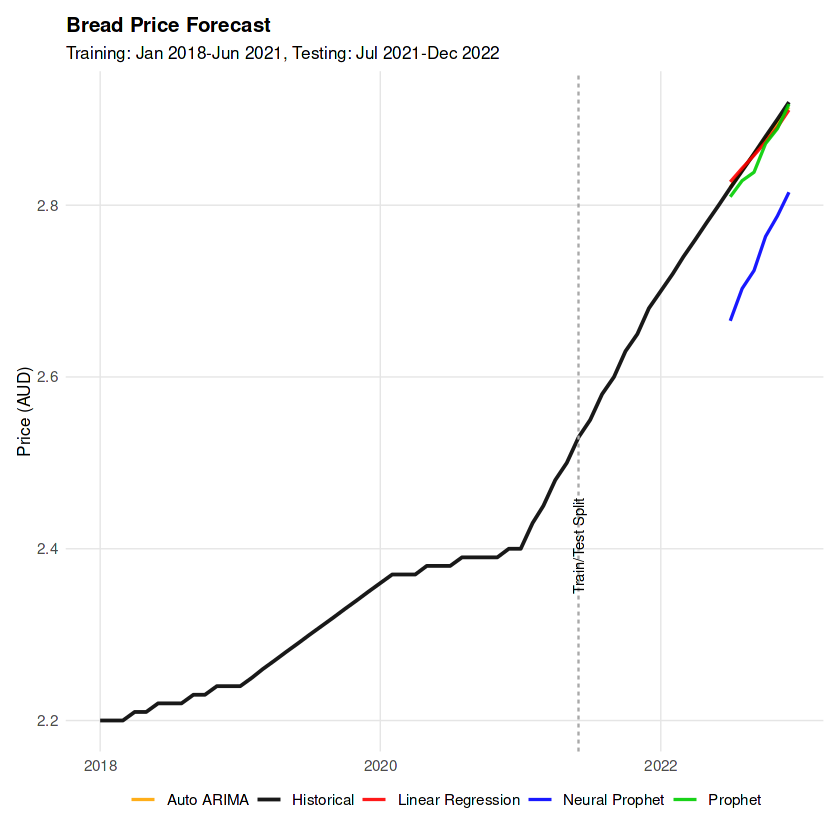


ANALYZING: Eggs 
Performing Feature Engineering...
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 5.552 6.133 
Historical range: 3.41 5.46 
Running Neural Prophet...
Neural Prophet completed successfully


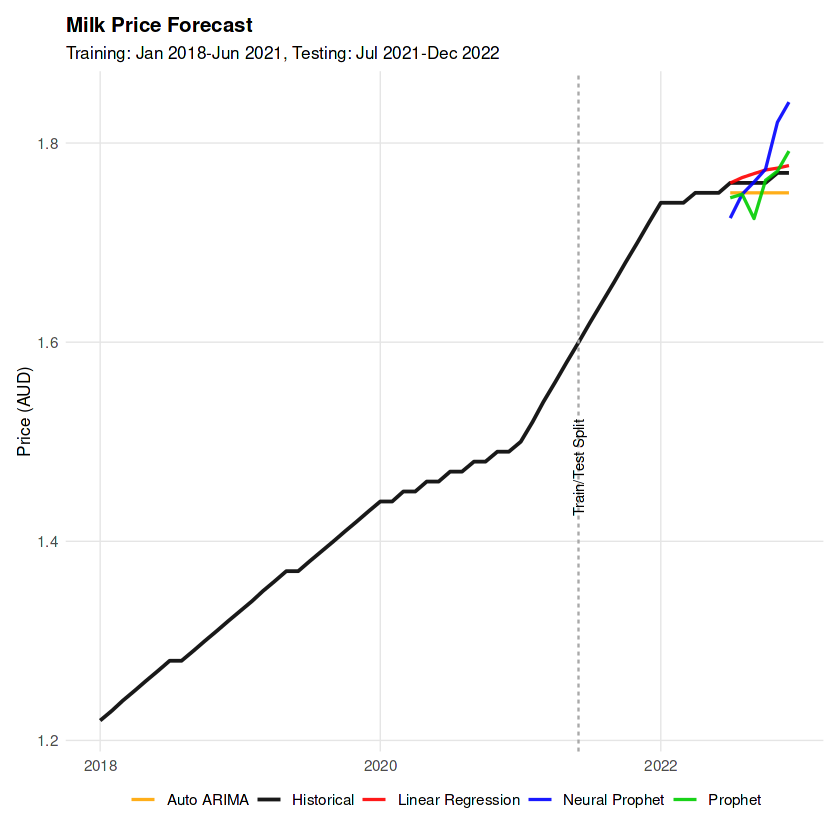


ANALYZING: Potatoes 
Performing Feature Engineering...
Running Enhanced Linear Regression...
Running Enhanced Auto ARIMA...
Running Enhanced Prophet (robust)...
Prophet forecast range: 3.952 3.992 
Historical range: 3.5 3.93 
Running Neural Prophet...
Neural Prophet completed successfully


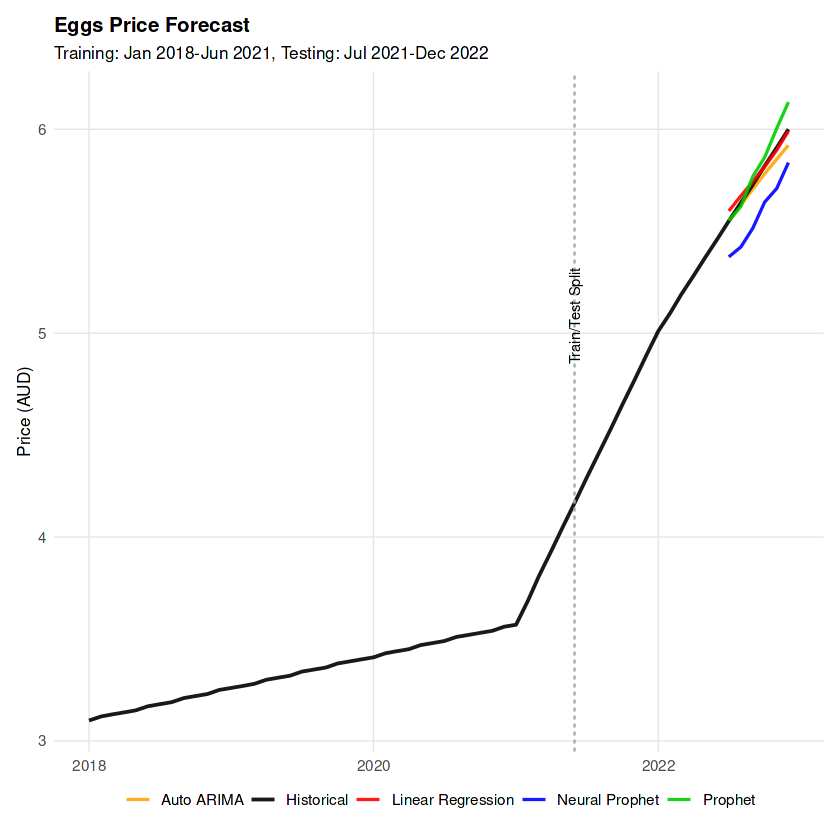


=== COMBINED VISUALIZATION OF ALL FOOD ITEMS ===


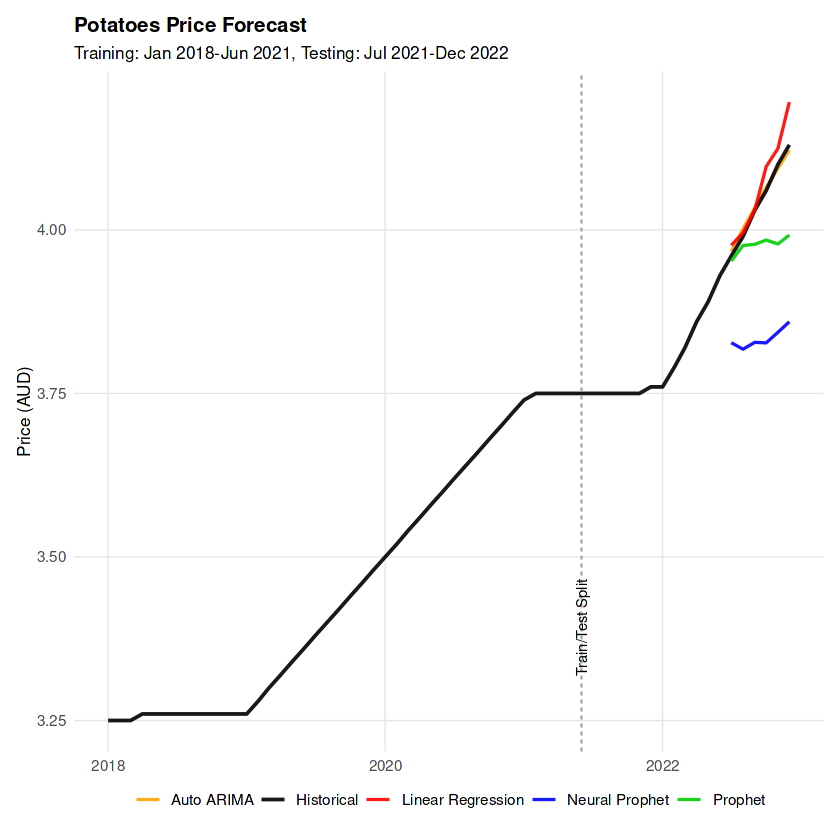

TableGrob (4 x 2) "arrange": 6 grobs
  z     cells    name                grob
1 1 (2-2,1-1) arrange     gtable[arrange]
2 2 (2-2,2-2) arrange     gtable[arrange]
3 3 (3-3,1-1) arrange     gtable[arrange]
4 4 (3-3,2-2) arrange     gtable[arrange]
5 5 (1-1,1-2) arrange text[GRID.text.813]
6 6 (4-4,1-2) arrange   gtable[guide-box]


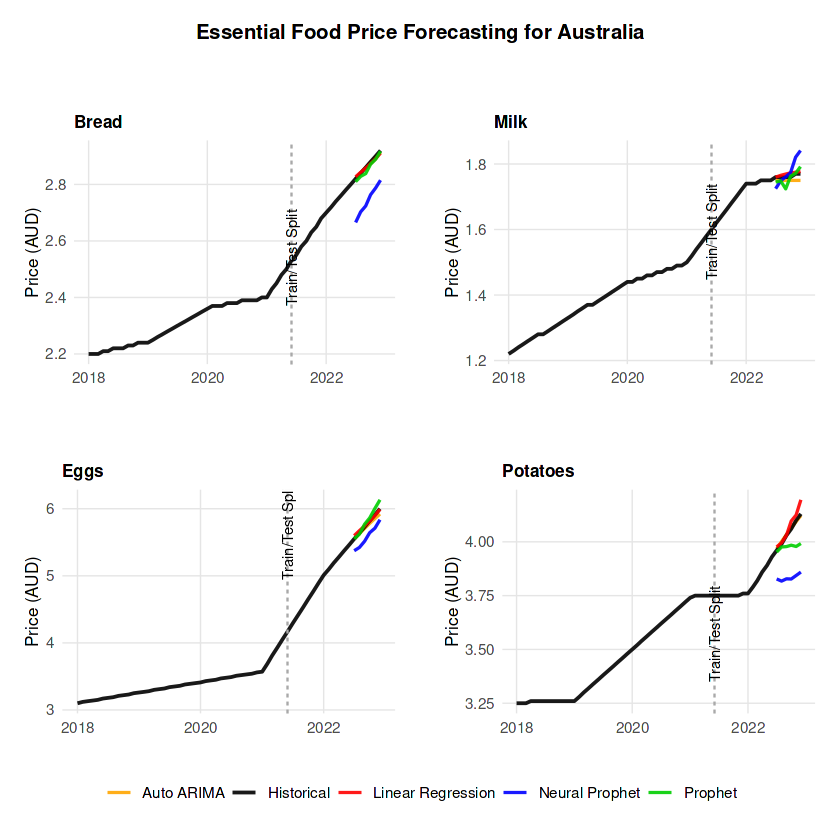

In [7]:
# --- 3. RUN COMPREHENSIVE ANALYSIS ---
cat("=== ESSENTIAL FOOD PRICE FORECASTING ANALYSIS ===\n")
cat("Training period: Jan 2018 - Jun 2021\n")
cat("Testing period: Jul 2021 - Dec 2022\n")

# Install required packages if not already installed
if (!require("knitr")) install.packages("knitr")

# Initialize results storage
all_results <- list()
all_metrics <- data.frame()

# Analyze each food item
for(item in names(food_items)) {
  # Add robust error handling
  tryCatch({
    result <- comprehensive_forecast_analysis(food_items[[item]], item)
    all_results[[item]] <- result
    
    # Add item name to metrics
    result$metrics$Item <- item
    all_metrics <- rbind(all_metrics, result$metrics)
  }, error = function(e) {
    cat("Error analyzing", item, ":", e$message, "\n")
    
    # ADDED: Create simpler fallback analysis
    cat("Attempting simpler analysis for", item, "...\n")
    tryCatch({
      # Get data splits
      train_data <- food_items[[item]] %>% 
        filter(date >= as.Date('2018-01-01') & date <= as.Date('2021-06-01'))
      test_data <- food_items[[item]] %>% 
        filter(date >= as.Date('2021-07-01') & date <= as.Date('2022-12-01'))
      test_actuals <- test_data$Average.Price
      
      # Simple linear model
      lm_simple <- lm(Average.Price ~ as.numeric(date), data = train_data)
      lm_preds <- predict(lm_simple, newdata = test_data)
      
      # Simple ARIMA
      ts_train <- ts(train_data$Average.Price, frequency = 12)
      arima_model <- auto.arima(ts_train)
      arima_preds <- forecast(arima_model, h = length(test_actuals))$mean
      
      # Create fallback metrics
      fallback_metrics <- data.frame(
        Model = c("Linear Regression", "Auto ARIMA"),
        MAE = c(mean(abs(lm_preds - test_actuals)), mean(abs(arima_preds - test_actuals))),
        RMSE = c(sqrt(mean((lm_preds - test_actuals)^2)), sqrt(mean((arima_preds - test_actuals)^2))),
        MAPE = c(mean(abs((test_actuals - lm_preds)/test_actuals) * 100), 
                mean(abs((test_actuals - arima_preds)/test_actuals) * 100)),
        R2 = c(1 - sum((test_actuals - lm_preds)^2) / sum((test_actuals - mean(test_actuals))^2),
              1 - sum((test_actuals - arima_preds)^2) / sum((test_actuals - mean(test_actuals))^2)),
        Item = item
      )
      
      all_metrics <- rbind(all_metrics, fallback_metrics)
      cat("Added fallback metrics for", item, "\n")
    }, error = function(e2) {
      cat("Fallback analysis also failed for", item, ":", e2$message, "\n")
    })
  })
}

# --- SHOW COMBINED VISUALIZATION FIRST ---
# Move this section before metrics tables
if(length(all_results) == 4 && all(sapply(all_results, function(x) !is.null(x$plot)))) {
  cat("\n=== COMBINED VISUALIZATION OF ALL FOOD ITEMS ===\n")
  
  # Add more spacing and reduce text size to avoid overlapping
  # Extract individual plots but remove their legends and simplify titles
  bread_plot <- all_results$Bread$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Bread", subtitle = NULL)
  
  milk_plot <- all_results$Milk$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Milk", subtitle = NULL)
  
  eggs_plot <- all_results$Eggs$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Eggs", subtitle = NULL)
  
  potatoes_plot <- all_results$Potatoes$plot + 
    theme(
      legend.position = "none",
      plot.title = element_text(size = 10, face = "bold"),
      plot.subtitle = element_blank(),
      plot.margin = margin(t = 15, r = 15, b = 15, l = 15)
    ) +
    labs(title = "Potatoes", subtitle = NULL)
  
  # Create a simplified legend
  legend <- get_legend(
    all_results$Bread$plot + 
      guides(color = guide_legend(nrow = 1)) +
      theme(legend.position = "bottom")
  )
  
  # Use layout_matrix to add more space between plots
  combined_plot <- grid.arrange(
    arrangeGrob(bread_plot, top = textGrob("")),
    arrangeGrob(milk_plot, top = textGrob("")),
    arrangeGrob(eggs_plot, top = textGrob("")),
    arrangeGrob(potatoes_plot, top = textGrob("")),
    ncol = 2,
    nrow = 2,
    bottom = legend,
    top = textGrob("Essential Food Price Forecasting for Australia",
                  gp = gpar(fontsize = 12, fontface = "bold")),
    padding = unit(2, "line")  # Add padding between plots
  )
  
  print(combined_plot)
}


In [8]:

# --- NOW SHOW METRICS TABLES AFTER VISUALIZATIONS ---
# Ensure create_simple_metrics_table can handle empty data
if(nrow(all_metrics) == 0) {
  cat("No analyses succeeded. Cannot create metric tables.\n")
} else {
  cat("\n=== MODEL PERFORMANCE METRICS ===\n")
  # Create simple metrics tables
  metrics_tables <- create_simple_metrics_table(all_metrics)
  
  # Display individual metric comparisons
  cat("\n=== METRIC COMPARISON ACROSS MODELS ===\n")
  
  # MAE comparison
  cat("\nMean Absolute Error (MAE) by Model and Food Item:\n")
  mae_comparison <- all_metrics %>%
    select(Model, Item, MAE) %>%
    pivot_wider(names_from = Item, values_from = MAE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(mae_comparison)
  
  # RMSE comparison
  cat("\nRoot Mean Square Error (RMSE) by Model and Food Item:\n")
  rmse_comparison <- all_metrics %>%
    select(Model, Item, RMSE) %>%
    pivot_wider(names_from = Item, values_from = RMSE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(rmse_comparison)
  
  # MAPE comparison
  cat("\nMean Absolute Percentage Error (MAPE) by Model and Food Item:\n")
  mape_comparison <- all_metrics %>%
    select(Model, Item, MAPE) %>%
    pivot_wider(names_from = Item, values_from = MAPE) %>%
    mutate(across(-Model, ~round(., 4)))
  print(mape_comparison)
  
  # R2 comparison
  cat("\nR-squared (R2) by Model and Food Item:\n")
  r2_comparison <- all_metrics %>%
    select(Model, Item, R2) %>%
    pivot_wider(names_from = Item, values_from = R2) %>%
    mutate(across(-Model, ~round(., 4)))
  print(r2_comparison)
  
  # Innovation R2 comparison
  cat("\nInnovation R-squared (Innovation_R2) by Model and Food Item:\n")
  innr2_comparison <- all_metrics %>%
    select(Model, Item, Innovation_R2) %>%
    pivot_wider(names_from = Item, values_from = Innovation_R2) %>%
    mutate(across(-Model, ~round(., 4)))
  print(innr2_comparison)
}


=== MODEL PERFORMANCE METRICS ===

Model Performance Metrics for Bread 
              Model    MAE   RMSE   MAPE       R2 Innovation_R2
1 Linear Regression 0.0062 0.0068 0.2141   0.9608        0.8882
2        Auto ARIMA 0.0021 0.0029 0.0731   0.9927        0.9748
3           Prophet 0.0108 0.0122 0.3777   0.8722        0.6048
4    Neural Prophet 0.1270 0.1281 4.4310 -13.0653      -36.2754

Model Performance Metrics for Milk 
              Model    MAE   RMSE   MAPE       R2 Innovation_R2
1 Linear Regression 0.0067 0.0078 0.3776  -1.7066       -2.6086
2        Auto ARIMA 0.0133 0.0141 0.7554  -8.0000      -10.0000
3           Prophet 0.0148 0.0188 0.8374 -14.9882      -18.0678
4    Neural Prophet 0.0306 0.0392 1.7309 -68.1599      -78.6916

Model Performance Metrics for Eggs 
              Model    MAE   RMSE   MAPE      R2 Innovation_R2
1 Linear Regression 0.0200 0.0256 0.3532  0.9722        0.9619
2        Auto ARIMA 0.0352 0.0437 0.5990  0.9191        0.7172
3           Prophet 0.05